# Libraries

In [ ]:
from tqdm.notebook import tqdm
from typing import Optional, Tuple


import cupy as cp
import numba as nb
from numba import cuda,float32,int32

import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
import math

import time

# Kernel Definitions

In [ ]:
@cuda.jit
def acceleration_direct(x, mass, acc):
  '''
  Compute the acceleration for each particle in a given configuration x via brute force approach.

  '''
  i_col = cuda.grid(1) #Cuda 1d-grid initialization, i_col map to a singular thread the computation

  n0, n1 = x.shape
  # threads_per_grid_row, threads_per_grid_col = cuda.gridsize(2)

  if i_col <n1: #Check for out of boundery indexes

    for j in range(x.shape[0]):

      temp = 0

      for i in range(x.shape[0]):

        if i!=j:
          r=0
          for k in range(n1):
            r += (x[j, k] - x[i, k])*(x[j, k] - x[i, k])

          temp -= mass[j]*(x[j, i_col] - x[i, i_col])/math.sqrt(r)

      acc[j, i_col] = temp



In [ ]:
@cuda.jit
def vv_pos(x0, v0, a0, dt, x1):
  '''
  Update the particle positions following the velocity-verlet schema.
  '''
  i_row, i_col = cuda.grid(2) #Cuda 2d-grid initialization, map to a singular thread the computation

  n0, n1 = x0.shape
  threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #Number of thread for each dimension in the grid

  for i0 in range(i_row, n0, threads_per_grid_x): #Stride loop in the 1st dimension, remap the problem for out of boundery threads
    for i1 in range(i_col, n1, threads_per_grid_y):#Stride loop in the 2nd dimension, remap the problem for out of boundery threads

      x1[i0, i1]  = x0[i0, i1]  + v0[i0, i1]*dt[0] + 0.5*a0[i0, i1]*dt[0]*dt[0] #Update positions


In [ ]:
@cuda.jit
def vv_vel(v0, a0, a1, dt, v1):
  '''
  Update the particle velocities following the velocity-verlet schema.
  '''
  i_row, i_col = cuda.grid(2) #Cuda 2d-grid initialization, map to a singular thread the computation

  n0, n1 = v0.shape
  threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #Number of thread for each dimension in the grid

  for i0 in range(i_row, n0, threads_per_grid_x): #Stride loop in the 1st dimension, remap the problem for out of boundery threads
    for i1 in range(i_col, n1, threads_per_grid_y): #Stride loop in the 2nd dimension, remap the problem for out of boundery threads

      v1[i0, i1] = v0[i0, i1] + 0.5 * (a0[i0, i1] + a1[i0, i1])*dt[0] #Update velocities


In [ ]:

@cuda.jit
def update(x1, v1, x0, v0):
  '''
  Copy into (x0,v0) the values of (x1, v1).
  '''
  i_row, i_col = cuda.grid(2) #Cuda 2d-grid initialization, map to a singular thread the computation

  n0, n1 = x1.shape
  threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #Number of thread for each dimension in the grid

  for i0 in range(i_row, n0, threads_per_grid_x): #Stride loop in the 1st dimension, remap the problem for out of boundery threads
    for i1 in range(i_col, n1, threads_per_grid_y): #Stride loop in the 2nd dimension, remap the problem for out of boundery threads
      x0[i0, i1] = x1[i0, i1] #Copy x1 into x0
      v0[i0, i1] = v1[i0, i1] #Copy v1 into v0

In [ ]:
def delta_np(x_np, mass):
  dx_np = np.zeros_like(x_np.copy(), dtype=float)

  for i in range(dx_np.shape[0]):
    for j in range(dx_np.shape[0]):
      if i!=j:
        # print(x_np[i] - x_np[j])
        dx_np[i] = dx_np[i] - mass[i]*(x_np[i].copy() - x_np[j].copy() )/np.sqrt(np.sum((x_np[i].copy()  - x_np[j].copy() )**2))

  return dx_np

# Test Integrator

## Parallelisation over Simulations

### Simulation Parameters

In [ ]:
N_particles = 100
N_dim  = 3 #(x,y,z)
N_streams = 5 #Number of simulation to be carried out in parallel
T = 200 #Number of simulation steps

### Streams Initialization

In [ ]:
streams = [cuda.stream() for _ in range(0, N_streams)] #Stream initializations, each simulation will be mapped to a different stream

### Configurations Initialization

In [ ]:
sim = np.zeros(shape=(N_streams, T, N_particles, N_dim)) #Array that will contain all the configuration generated by the simulations
                                                         #[Simulation, Simulation_step, Particle, coordinate]

#Configurations must be initialized for each simulation into the same array
#For example:
#x0: [N_simulation, N_particles, Coordinates]
#mass: [N_simulation, N_particles]

x0 = np.random.normal(loc=0, scale=1, size = (N_streams,
                                              N_particles,
                                              N_dim))
x1 = np.zeros((N_streams,
               N_particles,
               N_dim), dtype=np.float32)
v0 = np.random.normal(loc=0, scale=1, size = (N_streams,
                                              N_particles,
                                              N_dim))
v1 = np.zeros((N_streams,
               N_particles,
               N_dim), dtype=np.float32)
mass = np.random.uniform(low=0, high=1, size = (N_streams,
                                                N_particles))
acc0 = np.zeros((N_streams,
                 N_particles,
                 N_dim), dtype=np.float32)
acc1 = np.zeros((N_streams,
                 N_particles,
                 N_dim), dtype=np.float32)
dt = np.array([0.01])

### 2Body Configuration

In [ ]:
N_particles = 2
N_dim  = 3
N_streams = 5
T = 100

sim = np.zeros(shape=(N_streams, T, N_particles, N_dim), dtype=np.float32)

x0 = np.array([[[0,0,0],[1,0,0]],[[0,0,0],[2,0,0]],[[0,0,0],[3,0,0]],[[0,0,0],[4,0,0]],[[0,0,0],[5,0,0]]], dtype=np.float32)
x1 = np.zeros((N_streams, N_particles, N_dim), dtype=np.float32)

v0 = np.array([[[0,0,0], [1,0,0]],[[0,0,0], [1,0,0]],[[0,0,0], [1,0,0]],[[0,0,0], [1,0,0]],[[0,0,0], [1,0,0]]])
v1 = np.zeros((N_streams, N_particles, N_dim), dtype=np.float32)

mass = np.array([[10, 1], [10, 1], [10, 1], [10, 1], [10, 1]], dtype=np.float32)

acc0 = np.zeros((N_streams, N_particles, N_dim), dtype=np.float32)
acc1 = np.zeros((N_streams, N_particles, N_dim), dtype=np.float32)

dt = np.array([0.01])

### Copy to Device (Mi e' sorto ora un dubbio che cosi effettivamente funzioni il codice)

In [ ]:
#Each configuration is copied to the corrsponding device stream
for k, stream in enumerate(streams):

  with cuda.pinned(x0, x1, v0, v1, acc0, acc1, mass, dt): #Pinning tells the host to keep this variables in memory

    d_x0 = cuda.to_device(x0[k], stream=stream)
    d_x1 = cuda.to_device(x1[k], stream=stream)

    d_v0 = cuda.to_device(v0[k], stream=stream)
    d_v1 = cuda.to_device(v1[k], stream=stream)

    d_mass = cuda.to_device(mass[k], stream=stream)

    d_acc0 = cuda.to_device(acc0[k], stream=stream)
    d_acc1 = cuda.to_device(acc1[k], stream=stream)

    d_dt = cuda.to_device(dt, stream=stream)

### Kernels Grid Parameters

In [ ]:
threadsperblock = 256
blockspergrid = 64

### Benchmarck Parameters (TBD)

In [ ]:
rep = 10

parallel_average_t = []
parallel_std_t = []

### Parallel Simulations

In [ ]:
with cuda.pinned(sim): #We pin only sim since its the one into which the configurations will be copied

  # start = time.time()
  for t in range(T):
    for k, stream in enumerate(streams):


      acceleration_direct[blockspergrid, threadsperblock, stream](d_x0, d_mass, d_acc0)
      vv_pos[(blockspergrid, blockspergrid), threadsperblock, stream](d_x0, d_v0, d_acc0, d_dt, d_x1)
      acceleration_direct[blockspergrid, threadsperblock, stream](d_x1, d_mass, d_acc1)
      vv_vel[(blockspergrid, blockspergrid), threadsperblock, stream](d_v0, d_acc0, d_acc1, d_dt, d_v1)
      update[(blockspergrid, blockspergrid), threadsperblock, stream](d_x1, d_v1, d_x0, d_v0)
      # cuda.synchronize()


      d_x0.copy_to_host(sim[k,t], stream=stream) #Copy d_x0 into sim for each simulation and simulation step

    # np.save(f'runs/test{k}_{t}', x0[k])

# end = time.time()
# print(end-start)

0.23882079124450684


# Plots

In [ ]:
# filenames = [f'runs/test0_{t}.npy' for t in range(500)]
# combined_data = np.array([np.load(fname) for fname in filenames])

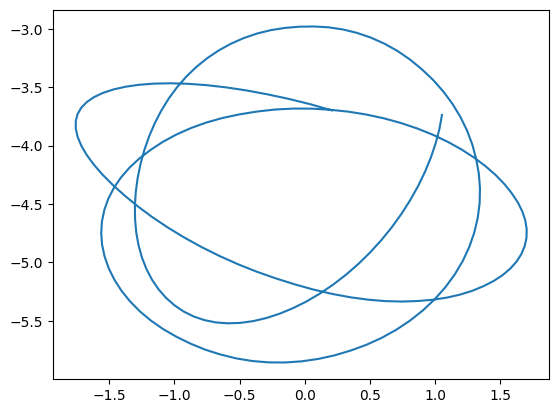

In [ ]:
plt.plot(sim[0,:,1,0], sim[0,:,1,1])